# Convoluted Neural Network: 1st Model Trial

## Imports

In [1]:
import numpy as np
import pandas as pd

## To be reconsidered at later date (RNN)

### Recurrent Neural Network Prep (to be reconsidered)

#### Sort dataframe by period !

First df needs to be sorted by period!

In [2]:
# sorted_df = df.sort_values(by = ['period'])

#### Train & Test Dataframe

In [3]:
# len_ = int(0.8 * sorted_df.shape[0])

In [4]:
# df_train = sorted_df[:len_]
# df_test = sorted_df[len_:]

#### Turning df_train and df_test into Gaussian 3D arrays

In [5]:
# img3D_conv = gaussian_filter(img_list, sigma=(2,2,2))

#### Splitting into sub-samples

**Decide how many observations (sample number) you need for a chosen observation 'length' (no. of images / hours)**

Sample the df as many times as the no. of observations indicated and split each into X and y.


get_X_y should call the split_subsample function, which in turn calls the subsample_sequence function.

i.e. first sample, then split, then store in X and y arrays


X_train and y_train should be extracted from the train dataframe (vice versa for X_test and y_test)!

## Dummie Model

### X and y

In [6]:
#X_ = np.random.randint(2, size = (50, 24, 1_000, 1_000)).astype(np.int32)

In [7]:
#y = np.array([np.random.randint(2, size = (3, 1_000, 1_000), dtype = int).flatten() for k in range(50)])

In [8]:
X = np.empty((24, 12, 100, 100))

y = np.array([np.empty((3, 100, 100), dtype = int).flatten() for k in range(24)])

In [9]:
print(X.shape)
print(y.shape)

(24, 12, 100, 100)
(24, 30000)


### Train, test, split

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [11]:
X_train.shape

(19, 12, 100, 100)

In [12]:
X_test.shape

(5, 12, 100, 100)

## CNN

In [13]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

In [14]:
model = models.Sequential()

In [15]:
model.add(layers.GaussianNoise(stddev = 2.5, input_shape = (12, 100, 100)))

In [16]:
model.add(layers.Conv2D(32, kernel_size = 3, activation = 'relu'))

In [17]:
model.add(layers.Conv2D(16, kernel_size = 3, activation = 'relu'))

In [18]:
model.add(layers.Flatten())

In [19]:
model.add(layers.Dense(3 * 100 * 100))

In [20]:
model.compile(loss = 'mse',
                  optimizer = 'adam',
                  metrics = 'mse')

In [21]:
model.fit(X_train, y_train)

1/1 [==============================] - 0s 1ms/step - loss: inf - mse: inf


In [22]:
print(model.evaluate(X_test, y_test))

1/1 [==============================] - 0s 2ms/step - loss: inf - mse: inf
[inf, inf]


## Checking with Real Data

In [23]:
import pickle

pickle_path = ('../raw_data/clean.pickle')
with open(pickle_path, 'rb') as f:
    df = pickle.load(f)

In [24]:
from datetime import datetime

In [25]:
inf = df['period'] > datetime(2016, 10, 1, 0, 0, 0)
sup = df['period'] < datetime(2016, 11, 1, 0, 0, 0)
sample = df[ inf & sup ]

In [26]:
def from_coord_to_matrix(df):
    #add 'time_index' column to df
    ind = {time:index for index,time in enumerate(np.sort(df['period'].unique()))}
    df['time_index'] = df['period'].map(ind)
    #initiate matrix
    grid_offset = np.array([0, -74.25559136315213, 40.49611539518921]) # Where do you start
    grid_spacing = np.array([1, 0.005, 0.005]) # What's the space you consider (euclidian here)
    #get points coordinates
    coords = np.array([(t_ind, lon, lat) for t_ind, lon, lat \
                   in zip(df['time_index'],df['longitude'],df['latitude'])])
    # Convert point to index
    indexes = np.round((coords - grid_offset)/grid_spacing).astype('int')
    #virgin matrix
    a = np.zeros((indexes[:,0].max()+1, indexes[:,1].max()+1, indexes[:,2].max()+1))
    Z = indexes[:,0]
    X = indexes[:,1]
    Y = indexes[:,2]
    a[Z, X, Y]=1
    return a

In [27]:
img = from_coord_to_matrix(sample)

<ipython-input-26-b7369d75031f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time_index'] = df['period'].map(ind)


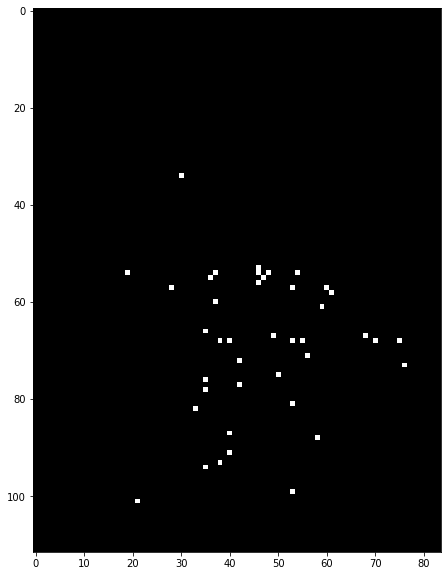

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.imshow(img[3], cmap='gray')

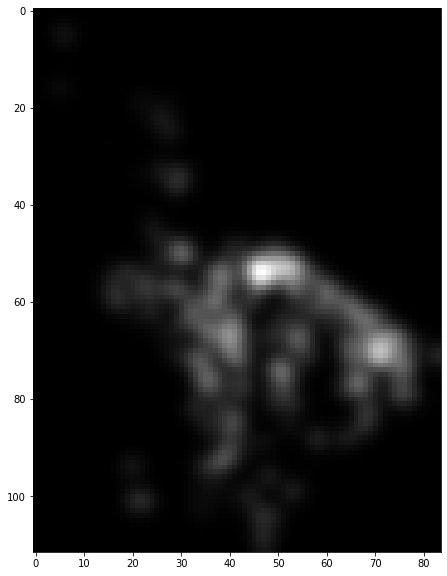

In [42]:
from scipy.ndimage import gaussian_filter

img3D_conv = gaussian_filter(img, sigma=(2, 2, 2))

plt.figure(figsize=(10,10))

plt.imshow(img3D_conv[3], cmap='gray')

In [43]:
def get_observation_target(img3D_conv):
    
    position = np.random.randint(0, img3D_conv.shape[0] - 12)
    
    observation = img3D_conv[position:position + 8]
    
    target = img3D_conv[position + 8:position + 12].flatten()
    
    return observation, target

In [44]:
def get_X_y(img3D_conv, number_of_observations):
    
    X = []
    y = []
    
    for n in range(number_of_observations):
        X_subsample, y_subsample = get_observation_target(img3D_conv)
        X.append(X_subsample)
        y.append(y_subsample)
        
    X = np.array(X)
    y = np.array(y)
    
    return X, y

In [45]:
X, y = get_X_y(img3D_conv, 10)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [47]:
X_train.shape

(8, 8, 112, 84)

In [48]:
y_train.shape

(8, 37632)

In [51]:
model_2 = models.Sequential()

model_2.add(layers.GaussianNoise(stddev = 2.5, input_shape = (8, 112, 84)))

model_2.add(layers.Conv2D(32, kernel_size = 3, activation = 'relu'))

model_2.add(layers.Conv2D(16, kernel_size = 3, activation = 'relu'))

model_2.add(layers.Flatten())

model_2.add(layers.Dense(4 * 112 * 84))

model_2.compile(loss = 'mse',
                  optimizer = 'adam',
                  metrics = 'mae')

model_2.fit(X_train, y_train)

1/1 [==============================] - 0s 5ms/step - loss: 0.6285 - mae: 0.6321


In [52]:
print(model_2.evaluate(X_test, y_test))

1/1 [==============================] - 0s 1ms/step - loss: 4.4099e-04 - mae: 0.0140
[0.00044099113438278437, 0.013981646858155727]
